In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from google.colab import files

# Load dataset
uploaded = files.upload()
df = pd.read_csv('final_preprocessed_dataset.csv')

# Drop History of Mental Illness_Yes as it's duplicate of Target
df = df.drop('History of Mental Illness_Yes', axis=1)

# Feature selection using LightGBM feature importance
temp_model = LGBMClassifier(random_state=42, verbose=-1)
temp_model.fit(df.drop('Target', axis=1), df['Target'])
selector = SelectFromModel(temp_model, prefit=True, max_features=10)
X_selected = selector.transform(df.drop('Target', axis=1))
selected_features = df.drop('Target', axis=1).columns[selector.get_support()].tolist()
print("Selected features for LightGBM:", selected_features)

# Update X with selected features
X = df[selected_features]
y = df['Target']

# Display basic dataset info
print("Dataset Shape:", df.shape)
print("Dataset Head:\n", df.head())
print("Dataset Info:")
df.info()

# Target distribution
print("Target Distribution:\n", df['Target'].value_counts(normalize=True))

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Confirmation that preprocessing is done
print("Missing Values:", df.isnull().sum().sum())
print("All columns are numeric:", all(np.issubdtype(dtype, np.number) for dtype in df.dtypes))

Saving final_preprocessed_dataset.csv to final_preprocessed_dataset.csv
Selected features for LightGBM: ['Age', 'Income', 'LFI']
Dataset Shape: (249450, 16)
Dataset Head:
         Age  Number of Children    Income  Education Level  Sleep Patterns  \
0  1.596498            1.378132 -1.226097              2.0             1.0   
1 -1.096950            0.569403 -0.186166              0.0             0.0   
2 -0.767140           -1.048056 -0.452160              0.0             2.0   
3 -0.107520           -1.048056 -0.574881              2.0             2.0   
4 -1.536697           -0.239327 -0.681067              0.0             1.0   

   Physical Activity Level  Alcohol Consumption  Dietary Habits  \
0                      1.0                  1.0             1.0   
1                      1.0                  1.0             0.0   
2                      1.0                  2.0             1.0   
3                      0.0                  0.0             1.0   
4                      2

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Base Model CV Results:
Accuracy: 0.5657 ± 0.0033
Precision: 0.5611 ± 0.0040
Recall: 0.6040 ± 0.0066
F1: 0.5817 ± 0.0022
Roc_auc: 0.5879 ± 0.0034


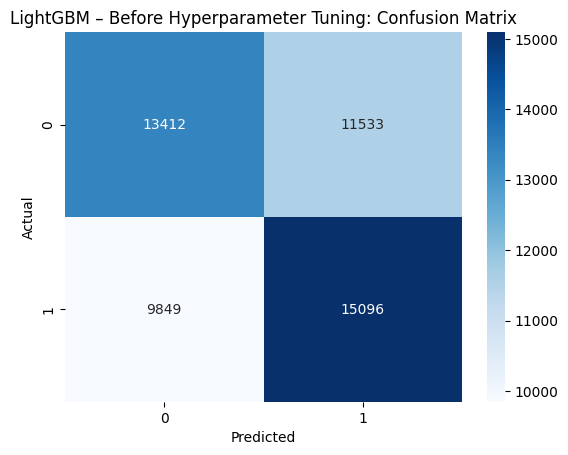

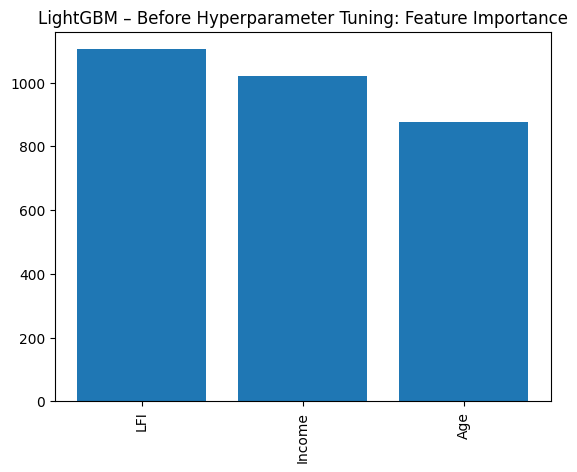

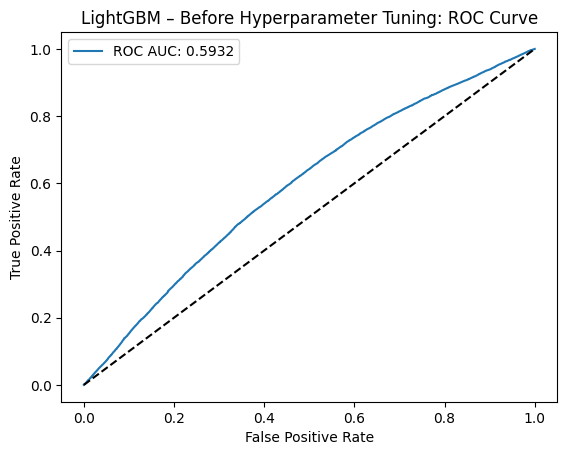

In [ ]:
# Initialize the base model with default parameters
model = LGBMClassifier(random_state=42, verbose=-1)

# 5-Fold Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)

# Display mean ± std of CV metrics
print("Base Model CV Results:")
for metric in scoring:
    print(f"{metric.capitalize()}: {cv_results['test_' + metric].mean():.4f} ± {cv_results['test_' + metric].std():.4f}")

# Train on full train set for further evaluation
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('LightGBM – Before Hyperparameter Tuning: Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature Importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(range(X.shape[1]), importances[indices])
plt.title('LightGBM – Before Hyperparameter Tuning: Feature Importance')
plt.xticks(range(X.shape[1]), np.array(selected_features)[indices], rotation=90)
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'ROC AUC: {roc_auc_score(y_test, y_prob):.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('LightGBM – Before Hyperparameter Tuning: ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best CV F1 Score: 0.5833383790348762
Tuned Model Test Results:
Accuracy: 0.5717779114050912
Precision: 0.5664847202109093
Recall: 0.6115854880737622
F1 Score: 0.5881717942786645
ROC AUC: 0.5948906363291685


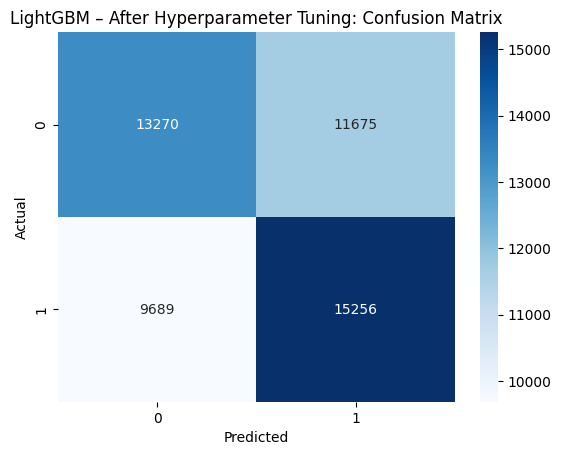

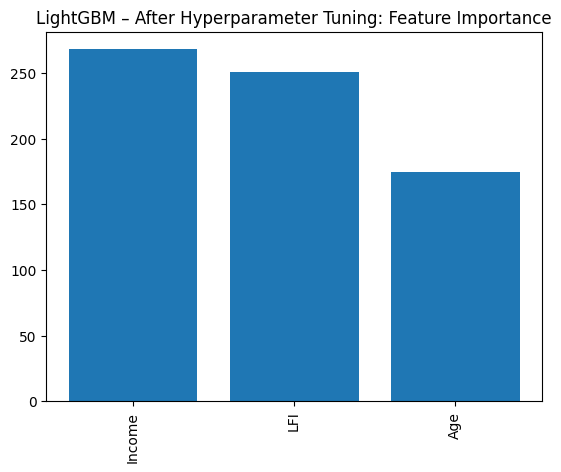

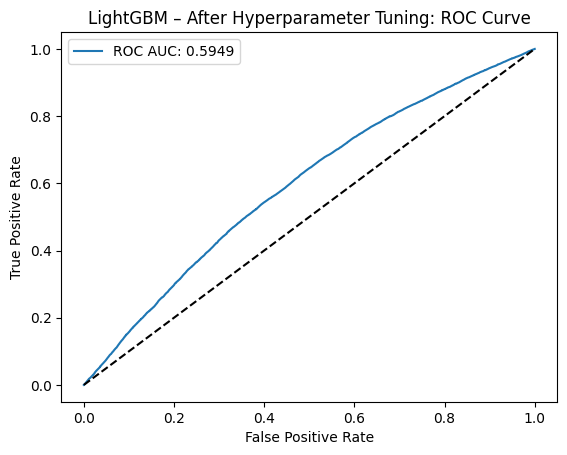

In [ ]:
# Hyperparameter Tuning with GridSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1]
}
grid_search = GridSearchCV(LGBMClassifier(random_state=42, verbose=-1), param_grid, cv=cv, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters and CV results
print("Best Parameters:", grid_search.best_params_)
print("Best CV F1 Score:", grid_search.best_score_)

# Retrain with best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# Improved metrics
print("Tuned Model Test Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

# Confusion matrix after tuning
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('LightGBM – After Hyperparameter Tuning: Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature Importance after tuning
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(range(X.shape[1]), importances[indices])
plt.title('LightGBM – After Hyperparameter Tuning: Feature Importance')
plt.xticks(range(X.shape[1]), np.array(selected_features)[indices], rotation=90)
plt.show()

# ROC Curve after tuning
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'ROC AUC: {roc_auc_score(y_test, y_prob):.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('LightGBM – After Hyperparameter Tuning: ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()